# Permanent Magnet Synchrone Motor


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline

from sklearn.preprocessing import Imputer
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score,mean_squared_error


from sklearn import svm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
#seaborn
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor



from sklearn import neighbors
from math import sqrt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# Any results you write to the current directory are saved as output.

data/pmsm_temperature_data.csv


## read data


In [2]:

#df = pd.read_csv('data/pmsm_temperature_data.csv', 
#                 usecols=[0,1,2,3,4,5,6,7,8,9,10,11])

df = pd.read_csv('data/pmsm_temperature_data.csv')
#df = pd.read_csv('../input/pmsm_temperature_data.csv', 
 #                usecols=[0,1,2,3,4,5,6,7,8,9,10,11])
df.head(10)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4
5,-0.762936,-1.116955,0.334901,-1.303017,-1.222429,-0.248197,1.031031,-0.246341,-2.522203,-1.831931,-2.062549,-2.017884,4
6,-0.749228,-1.116170,0.335014,-1.302082,-1.222430,-0.247914,1.030493,-0.246162,-2.522538,-1.833012,-2.062115,-2.017243,4
7,-0.738450,-1.113986,0.336256,-1.305155,-1.222432,-0.248321,1.030107,-0.246035,-2.522844,-1.832182,-2.061953,-2.017213,4
8,-0.730910,-1.111828,0.334905,-1.303790,-1.222432,-0.247785,1.029851,-0.245981,-2.522808,-1.831576,-2.062443,-2.017739,4
9,-0.727130,-1.109486,0.335988,-1.305633,-1.222431,-0.248294,1.029636,-0.245888,-2.522677,-1.831438,-2.062317,-2.018180,4


## data description


In [ ]:
df.info()


In [101]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
ambient,998070.0,-0.003905,0.993127,-8.573954,-0.599385,0.266157,0.686675,2.967117
coolant,998070.0,0.004723,1.002423,-1.429349,-1.037925,-0.177187,0.650709,2.649032
u_d,998070.0,0.004780,0.997878,-1.655373,-0.826359,0.267542,0.358491,2.274734
u_q,998070.0,-0.005690,1.002330,-1.861463,-0.927390,-0.099818,0.852625,1.793498
motor_speed,998070.0,-0.006336,1.001229,-1.371529,-0.951892,-0.140246,0.853584,2.024164
torque,998070.0,-0.003333,0.997907,-3.345953,-0.266917,-0.187246,0.547171,3.016971
i_d,998070.0,0.006043,0.998994,-3.245874,-0.756296,0.213935,1.013975,1.060937
i_q,998070.0,-0.003194,0.997912,-3.341639,-0.257269,-0.190076,0.499260,2.914185
pm,998070.0,-0.004396,0.995686,-2.631991,-0.672308,0.094367,0.680691,2.917456
stator_yoke,998070.0,0.000609,1.001049,-1.834688,-0.747265,-0.057226,0.697344,2.449158


In [ ]:
df.isnull().values.any()


In [ ]:
nans=pd.isnull(df).sum()
nans[nans>0]

In [ ]:
df.dtypes.value_counts()

In [ ]:
df.corr()

In [3]:
import seaborn as sns
%matplotlib inline

#reduced_df = df.copy().drop(['profile_id', 'stator_yoke', 'stator_winding'], axis=1)
reduced_df = df.copy().drop(['profile_id'], axis=1)




In [ ]:
#sns.jointplot(x='i_d', y='motor_speed', data=df,  kind='reg')
#sns.pairplot(df.sample(1000))
sns.pairplot(reduced_df.sample(frac=0.01))

plt.show()

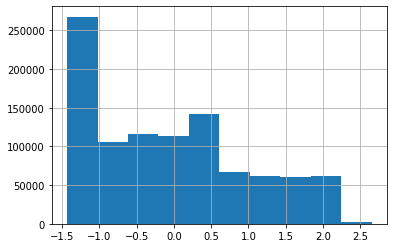

In [4]:
reduced_df['coolant'].hist()

In [ ]:
# import pipeline
from sklearn.pipeline import Pipeline

# Preprocessing for categorical data
#data_transformer = Pipeline(steps=[
#    ('normalize_scale', MaxAbsScaler()),
#    ('transform', OneHotEncoder(handle_unknown='ignore'))
#])


In [28]:
# scale and normalization
# log normalization 
# coolant is long right tail 
#df['newCoolantlog'] = df.coolant.map(np.log)
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, MaxAbsScaler
ss = StandardScaler() # -> 0.773837209163774
#ss = Normalizer() # -> used for NLP TF Idf but what ?
#ss = MinMaxScaler()# -> good 
#ss =    MaxAbsScaler()# ->  0.27318492751506374
# Apply scaler to numeric colu
df2 = df.copy()

coolant = df2['coolant']
newCoolant = np.sign(coolant)*np.log(abs(coolant))
df2moisCoolant = df2.drop(['coolant'], axis =1)
df2moisCoolant['newCoolant'] = newCoolant
ss.fit(df2moisCoolant)
from pandas import DataFrame

df_scaled = DataFrame(ss.transform(df2moisCoolant, copy=True), columns=df2moisCoolant.columns)
#df_scaled['newCoolant'] = newCoolant

df_scaled_reduced = df_scaled.drop([ 'profile_id','stator_yoke', 'stator_winding'], axis=1)

# pca selection
#from sklearn.decomposition import PCA
#pca = PCA()
#df_scaled_reduced_pca = DataFrame(pca.fit_transform(df_scaled_reduced), columns=df_scaled_reduced.columns )
#print(pca.explained_variance_ratio_)

#df_scaled_reduced_pca.describe().T


ambient         1.0
u_d             1.0
u_q             1.0
motor_speed     1.0
torque          1.0
i_d             1.0
i_q             1.0
pm              1.0
stator_tooth    1.0
newCoolant      1.0
dtype: float64

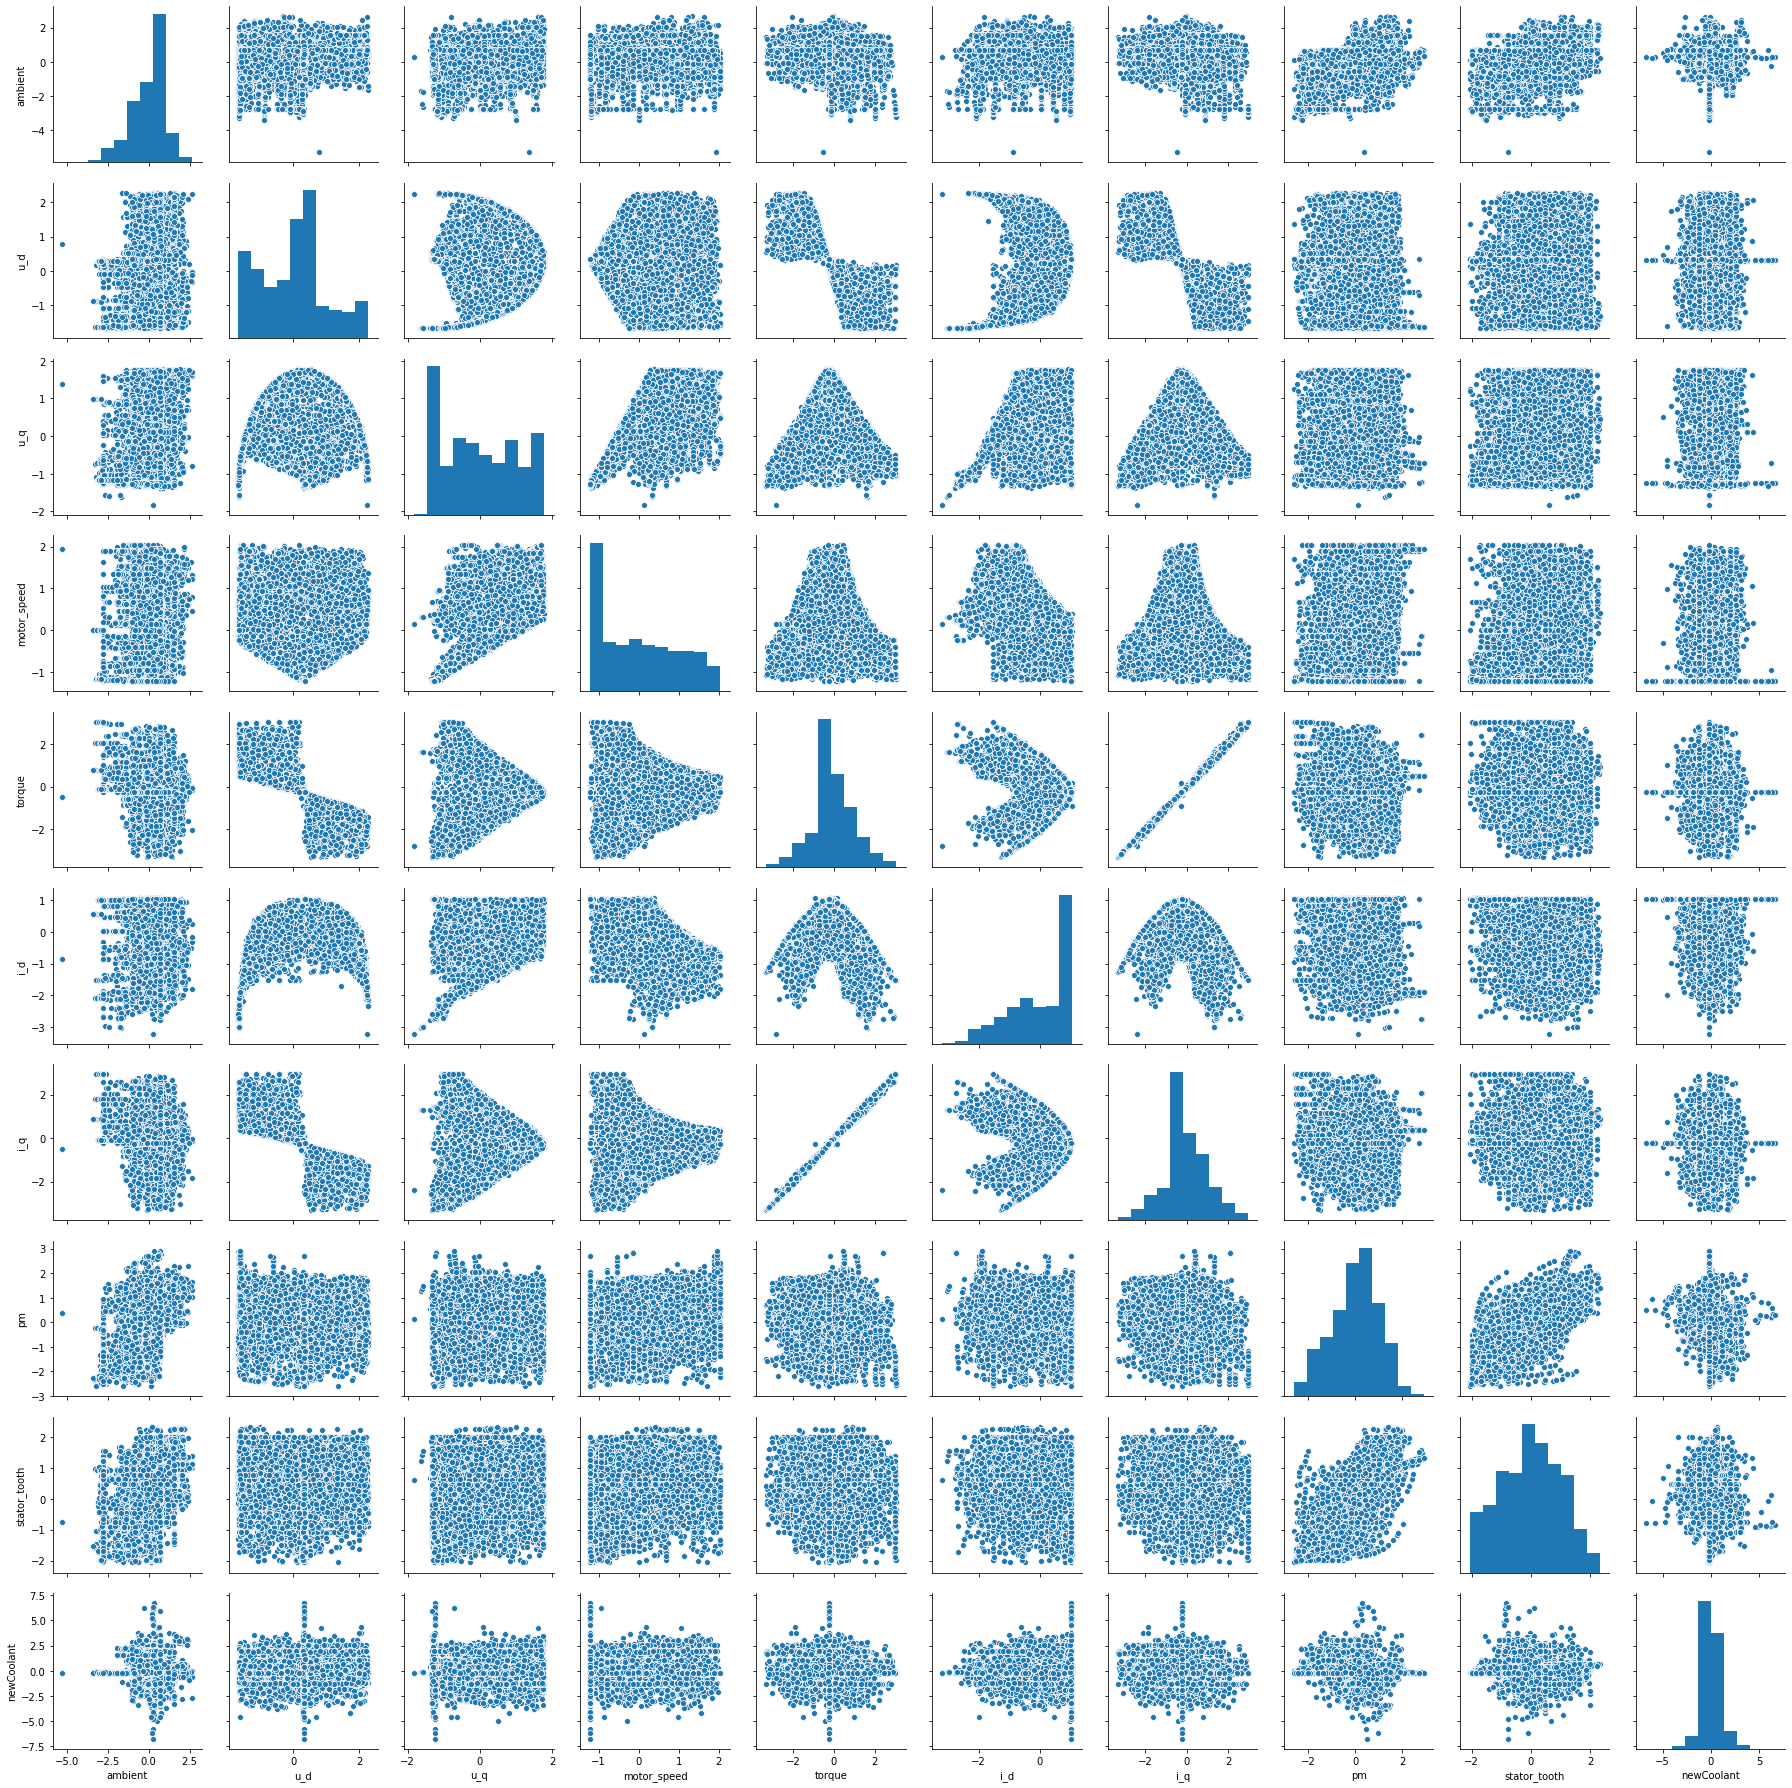

In [5]:
# plot scaled

sns.pairplot(df_scaled_reduced.sample(frac=0.01))
df_scaled_reduced.describe().T
np.var(df_scaled_reduced,axis=0)



&lt;matplotlib.axes._subplots.AxesSubplot at 0x7f8ff3f03150&gt;

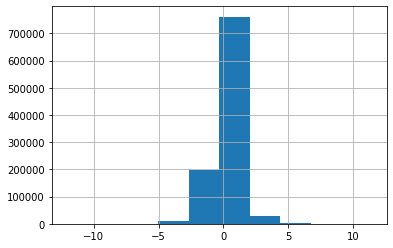

In [6]:
# new coolant scaled : log transformation from coolant
df_scaled_reduced['newCoolant'].hist( )



In [ ]:
#reduced_df = df.drop(['stator_yoke', 'stator_tooth', 'stator_winding'], axis=1)
matplotlib.rcParams.update({'font.size': 22})
g = sns.PairGrid(df_scaled_reduced.sample(frac=0.01))
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

## correlation map

In [ ]:
#correlation map
f,ax=plt.subplots(figsize=(15,15))
matplotlib.rcParams.update({'font.size': 8})

corr=df.corr()

sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.5, cbar_kws={"shrink": .5},
            mask= np.zeros_like(corr,dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            square=True, ax=ax)



plt.show()

In [ ]:
# il faut ajouter une feature executionTime per profile
## pas necessaire car l'état de demarrage est aléatoire (le moteur peut ne pas commencer à froid lors d'une session)

In [7]:
X=df_scaled_reduced.drop(["pm" ,"torque", "stator_tooth"], axis=1)
y=df_scaled_reduced["pm"]

X2=reduced_df.drop(["pm" , "torque", 'stator_tooth','stator_yoke', 'stator_winding'], axis=1)
y2=reduced_df["pm"]

#X3=df_scaled_reduced_pca.drop(["pm" ,"torque", "stator_tooth"], axis=1)
#y3=df_scaled_reduced_pca["pm"]


from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)
X2_train,X2_test,y2_train,y2_test=train_test_split(X2,y2,test_size=0.2, random_state=42)
#X3_train,X3_test,y3_train,y3_test=train_test_split(X3,y3,test_size=0.2, random_state=42)

training=df.copy()

# lasso

In [7]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, MaxAbsScaler
ss = StandardScaler() # -> 0.773837209163774
#ss = Normalizer() # -> used for NLP TF Idf but what ?
#ss = MinMaxScaler()# -> good 
#ss =    MaxAbsScaler()# ->  0.27318492751506374
# Apply scaler to numeric colu
dfLasso = df.copy()

X=dfLasso.drop(["pm" ,"torque", "stator_tooth",'profile_id','stator_yoke', 'stator_winding'], axis=1)
y=dfLasso["pm"]

coolant = X['coolant']
newCoolant = np.sign(coolant)*np.log(abs(coolant))
X = X.drop(['coolant'], axis =1)
X['newCoolant'] = newCoolant

from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

X_train_transformed = ss.fit_transform(X_train)
y_train_transformed = ss.fit_transform(pd.DataFrame(y_train, columns =['pm'] ))
X_test_transformed = ss.fit_transform(X_test)
y_test_transformed = ss.fit_transform(pd.DataFrame(y_test, columns =['pm'] ))

In [8]:
#régression Lasso, paramètres par défaut (alpha = 1.0)
from sklearn.linear_model import Lasso, LassoCV
lasso = Lasso(fit_intercept=False,normalize=False)
print(lasso)
Lasso(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=1000,
 normalize=False, positive=False, precompute=False, random_state=None,
 selection='cyclic', tol=0.0001, warm_start=False)
#apprentissage
lasso.fit(X_train_transformed,y_train_transformed)
print(lasso.coef_)

Lasso(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection=&#39;cyclic&#39;, tol=0.0001, warm_start=False)
[ 0. -0.  0.  0. -0. -0. -0.]


In [9]:
# compute alphas for lasso
my_alphas = np.array([0.0001,0.001,0.002,0.003,0.004,0.007,0.009,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6])
#obtention des valeurs des coefs. corresp.
from sklearn.linear_model import lasso_path
alpha_for_path, coefs_lasso, _ = lasso_path(X_train,y_train,alphas=my_alphas)
print(coefs_lasso.shape) 

(7, 15)


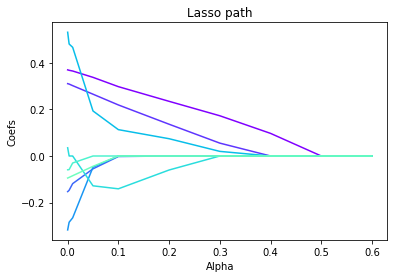

In [7]:
#lass path
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0,1,16))
#graphique lasso path (une courbe par variable)
for i in range(coefs_lasso.shape[0]):
 plt.plot(alpha_for_path,coefs_lasso[i,:],c=colors[i])

plt.xlabel('Alpha')
plt.ylabel('Coefs')
plt.title('Lasso path')
plt.show()

     alpha  Nb non-zero coefs
0   0.6000                  0
1   0.5000                  0
2   0.4000                  1
3   0.3000                  3
4   0.2000                  4
5   0.1000                  5
6   0.0500                  7
7   0.0100                  7
8   0.0090                  7
9   0.0070                  7
10  0.0040                  7
11  0.0030                  8
12  0.0020                  8
13  0.0010                  8
14  0.0001                  8


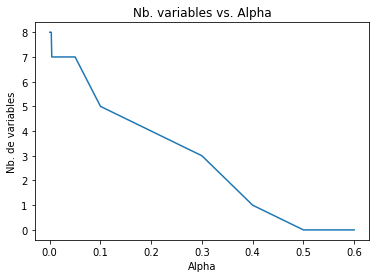

     Variables  Coefficients
0      ambient      0.366027
1      coolant      0.304760
2          u_d     -0.130511
3          u_q     -0.273357
4  motor_speed      0.472432
5          i_d     -0.000000
6          i_q     -0.041979
7   newCoolant     -0.087653


In [9]:
#nombre de coefs. non-nuls pour chaque alpha
import pandas
nbNonZero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso,axis=0)
print(pandas.DataFrame({'alpha':alpha_for_path,'Nb non-zero coefs':nbNonZero}))

plt.plot(alpha_for_path,nbNonZero)
plt.xlabel('Alpha')
plt.ylabel('Nb. de variables')
plt.title('Nb. variables vs. Alpha')
plt.show()

#nom des variables
nom_var = X_train.columns
#coefficients pour alpha=0.007 (colonne n°9)
coefsForAlpha = coefs_lasso[:,9]
#affichage des coefficients pour alpha = 0.007
print(pandas.DataFrame({'Variables':nom_var,'Coefficients':coefsForAlpha}))

In [10]:
#outil pour la détection de la solution la plus performante en validation croisée
#random_state = 0 pour fixer l’initialisation du générateur de nombre aléatoire
#cv = 5 pour 5-fold validation croisée
lcv = LassoCV(alphas=my_alphas,normalize=False,fit_intercept=False,random_state=0,cv=5)

#lancement sur l'échantillon d'apprentissage
lcv.fit(X_train_transformed,y_train_transformed) 
print(lcv.alphas_) 
#valeurs des MSE en validation croisée
print(lcv.mse_path_)




[6.e-01 5.e-01 4.e-01 3.e-01 2.e-01 1.e-01 5.e-02 1.e-02 9.e-03 7.e-03
 4.e-03 3.e-03 2.e-03 1.e-03 1.e-04]
[[0.99447583 0.99722149 0.99793281 1.00509859 1.00527132]
 [0.99152325 0.99602238 0.99570465 1.00429528 1.00527132]
 [0.90325327 0.90586037 0.90666245 0.91379378 0.91389255]
 [0.8019773  0.80303986 0.80483037 0.81102955 0.80976328]
 [0.67534036 0.67519473 0.67758522 0.68123608 0.67920029]
 [0.59691514 0.59531601 0.59808707 0.59992089 0.59787355]
 [0.55572681 0.55388288 0.55713887 0.55724818 0.55562437]
 [0.52486519 0.52062095 0.52382727 0.52293222 0.52183404]
 [0.52462431 0.5203247  0.52353273 0.52262257 0.52154032]
 [0.52422633 0.51981873 0.52303026 0.52208907 0.52103799]
 [0.5238553  0.51928927 0.52250424 0.52151825 0.5205138 ]
 [0.52378375 0.51916918 0.52238853 0.52138683 0.52040055]
 [0.52362043 0.51894839 0.52215933 0.52114563 0.52015877]
 [0.52354639 0.51881529 0.52201296 0.52099043 0.5199692 ]
 [0.52355846 0.51877504 0.52195995 0.52093092 0.5198782 ]]


     alpha       MSE
0   0.6000  1.000000
1   0.5000  0.998563
2   0.4000  0.908692
3   0.3000  0.806128
4   0.2000  0.677711
5   0.1000  0.597623
6   0.0500  0.555924
7   0.0100  0.522816
8   0.0090  0.522529
9   0.0070  0.522040
10  0.0040  0.521536
11  0.0030  0.521426
12  0.0020  0.521207
13  0.0010  0.521067
14  0.0001  0.521021


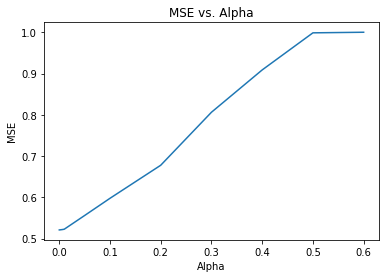

best alpha
0.0001


In [11]:
#moyenne mse en validation croisée pour chaque alpha
avg_mse = np.mean(lcv.mse_path_,axis=1)
#alphas vs. MSE en cross-validation
print(pandas.DataFrame({'alpha':lcv.alphas_,'MSE':avg_mse})) 
#sous-forme graphique
plt.plot(lcv.alphas_,avg_mse)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('MSE vs. Alpha')
plt.show()

#best alpha
print('best alpha')
print(lcv.alpha_) 

In [15]:
ypredictedtestLasso = lcv.predict(X_test_transformed)
ypLassoinversed = ss.inverse_transform(ypredictedtestLasso)

#LassoRmseTest=np.sqrt(mean_squared_error(y_test,ypLassoinversed))
#LassoRmseTest
# performance de prediction
print('MSE')
mean_squared_error(y_test,ypLassoinversed)

0.5160979721893504

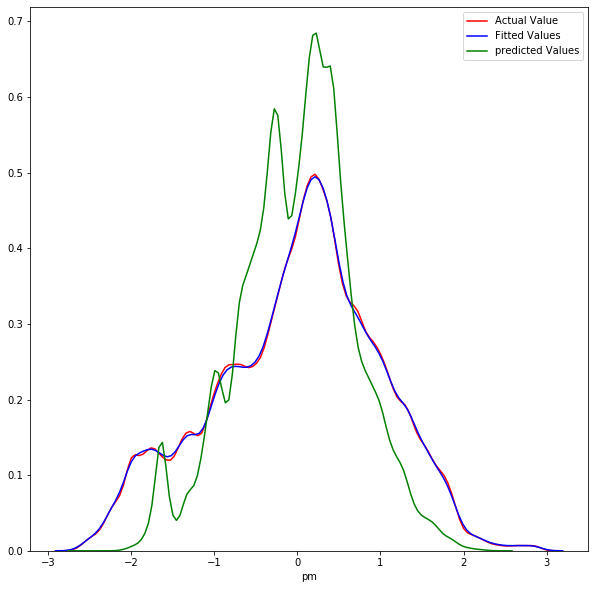

In [16]:
import seaborn as sns
f,ax=plt.subplots(figsize=(10,10))
matplotlib.rcParams.update({'font.size': 10})
ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax1);
sns.distplot(ypLassoinversed, hist=False, color="g", label="predicted Values" , ax=ax1);

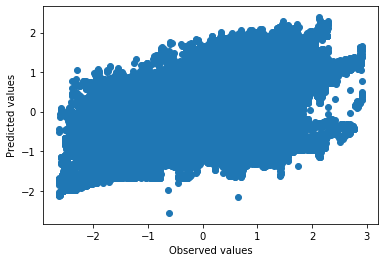

In [17]:
import numpy
#graphique
import matplotlib.pyplot as plt
ax = plt.scatter(y_test,ypLassoinversed)
#plt.scatter(y2_test,y2preditTest)
#plt.plot(numpy.arange(0,1.3),numpy.arange(0,1.3))
plt.xlabel("Observed values")
plt.ylabel("Predicted values")
plt.show()

OLS

In [13]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, MaxAbsScaler
#ss = StandardScaler() # -> 0.773837209163774
ss = MinMaxScaler()# -> good 
#ss =    MaxAbsScaler()# ->  0.27318492751506374
# Apply scaler to numeric colu
dfOLS = df.copy()

X=dfOLS.drop(["pm" ,"torque", "stator_tooth",'profile_id','stator_yoke', 'stator_winding'], axis=1)
y=dfOLS["pm"]

coolant = X['coolant']
newCoolant = np.sign(coolant)*np.log(abs(coolant))
X = X.drop(['coolant'], axis =1)
X['newCoolant'] = newCoolant

X.info()
X.columns 

from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

X_train_transformed = pd.DataFrame(ss.fit_transform(X_train), columns= X.columns)
y_train_transformed = pd.DataFrame(ss.fit_transform(pd.DataFrame(y_train, columns=['pm'] )), columns=['pm'])
X_test_transformed = pd.DataFrame(ss.fit_transform(X_test) , columns=X.columns)
y_test_transformed = pd.DataFrame(ss.fit_transform(pd.DataFrame(y_test, columns =['pm'] )), columns=['pm'])

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 7 columns):
ambient        998070 non-null float64
u_d            998070 non-null float64
u_q            998070 non-null float64
motor_speed    998070 non-null float64
i_d            998070 non-null float64
i_q            998070 non-null float64
newCoolant     998070 non-null float64
dtypes: float64(7)
memory usage: 53.3 MB


In [14]:
import statsmodels.api as sm
lm=sm.OLS(y_train_transformed, X_train_transformed)

ols=lm.fit()
ols.summary() #All coefficients are significant for the model by looking at the p-value. ( P>|t| )
#print(model.pvalues)



&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     pm   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                          1.402e+06
Date:                Mon, 05 Oct 2020   Prob (F-statistic):                        0.00
Time:                        02:59:13   Log-Likelihood:                      4.4315e+05
No. Observations:              798456   AIC:                                 -8.863e+05
Df Residuals:                  798449   BIC:                                 -8.862e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P&gt;|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ambient         1.0156      0.002    606.459      0.000       1.012       1.019
u_d            -0.1125      0.001   -110.254      0.000      -0.114      -0.110
u_q            -0.1943      0.001   -174.579      0.000      -0.197      -0.192
motor_speed     0.3024      0.001    210.813      0.000       0.300       0.305
i_d             0.0284      0.001     22.701      0.000       0.026       0.031
i_q            -0.1063      0.001    -73.359      0.000      -0.109      -0.103
newCoolant     -0.4295      0.003   -142.686      0.000      -0.435      -0.424
==============================================================================
Omnibus:                     1451.568   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1800.804
Skew:                          -0.005   Prob(JB):                         0.00
Kurtosis:                       3.232   Cond. No.                         32.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
&quot;&quot;&quot;

In [15]:
import statsmodels.api as sm
lm2=sm.OLS(y_train, X_train)

ols2=lm2.fit()
ols2.summary()#All coefficients are significant for the model by looking at the p-value. ( P>|t| )


&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     pm   R-squared (uncentered):                   0.401
Model:                            OLS   Adj. R-squared (uncentered):              0.401
Method:                 Least Squares   F-statistic:                          7.639e+04
Date:                Mon, 05 Oct 2020   Prob (F-statistic):                        0.00
Time:                        02:59:36   Log-Likelihood:                     -9.2476e+05
No. Observations:              798456   AIC:                                  1.850e+06
Df Residuals:                  798449   BIC:                                  1.850e+06
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P&gt;|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ambient         0.5007      0.001    554.376      0.000       0.499       0.502
u_d            -0.1345      0.002    -81.629      0.000      -0.138      -0.131
u_q            -0.3206      0.002   -170.030      0.000      -0.324      -0.317
motor_speed     0.5408      0.003    193.057      0.000       0.535       0.546
i_d             0.0676      0.002     35.458      0.000       0.064       0.071
i_q            -0.0620      0.002    -37.194      0.000      -0.065      -0.059
newCoolant     -0.0874      0.001    -99.915      0.000      -0.089      -0.086
==============================================================================
Omnibus:                     1557.886   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1948.448
Skew:                          -0.005   Prob(JB):                         0.00
Kurtosis:                       3.242   Cond. No.                         6.86
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
&quot;&quot;&quot;

In [17]:
# OLS MSE
from sklearn.metrics import r2_score,mean_squared_error

yPredictedTestOls1 = ols.predict(X_test_transformed)
yPredictedTestOls1Inversed = ss.inverse_transform(pd.DataFrame(yPredictedTestOls1 , columns =['pm'] ))

olsRmse=mean_squared_error(y_test,yPredictedTestOls1Inversed)
olsRmse

0.7875362754132154

In [18]:
#OLS2 MSE

yPredictedTestOls2 = ols2.predict(X_test)
ols2Rmse = mean_squared_error(y_test ,yPredictedTestOls2)
ols2Rmse

0.5936519013518646

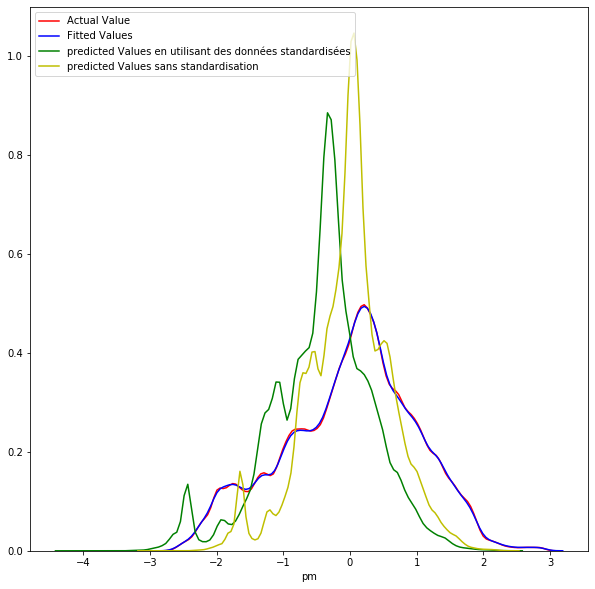

In [23]:
#Visualizing for Multiple Linear Regression y values model1

import seaborn as sns
f,ax=plt.subplots(figsize=(10,10))
matplotlib.rcParams.update({'font.size': 10})
ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax1);
sns.distplot(yPredictedTestOls1Inversed, hist=False, color="g", label="predicted Values en utilisant des données standardisées" , ax=ax1);
sns.distplot(yPredictedTestOls2, hist=False, color="y", label="predicted Values sans standardisation" , ax=ax1);



[&lt;matplotlib.lines.Line2D at 0x7fd8a32b6b10&gt;]

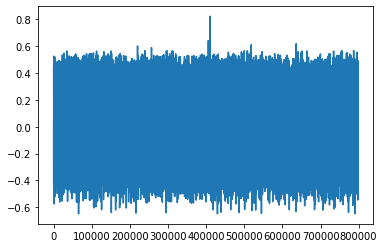

In [20]:
matplotlib.rcParams['agg.path.chunksize'] = 10000
plt.plot(ols.resid)



[&lt;matplotlib.lines.Line2D at 0x7fd8a3332f90&gt;]

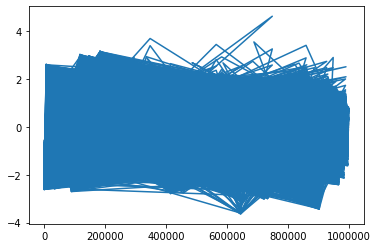

In [21]:
matplotlib.rcParams['agg.path.chunksize'] = 10000
plt.plot(ols2.resid)

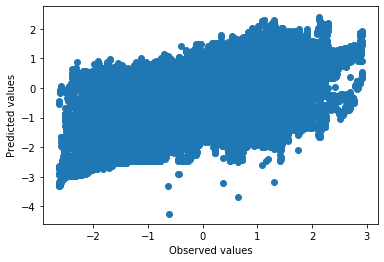

In [24]:
import numpy
#graphique
import matplotlib.pyplot as plt
ax = plt.scatter(y_test,yPredictedTestOls1Inversed)
#plt.scatter(y2_test,y2preditTest)
#plt.plot(numpy.arange(0,1.3),numpy.arange(0,1.3))
plt.xlabel("Observed values")
plt.ylabel("Predicted values")
plt.show()

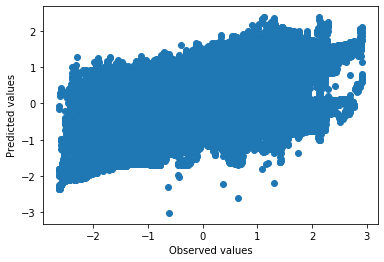

In [25]:
# model sans le scaling
import numpy
#graphique
import matplotlib.pyplot as plt
ax = plt.scatter(y_test,yPredictedTestOls2)
#plt.scatter(y2_test,y2preditTest)
#plt.plot(numpy.arange(0,1.3),numpy.arange(0,1.3))
plt.xlabel("Observed values")
plt.ylabel("Predicted values")
plt.show()

Text(0, 0.5, &#39;predicted vs actual pm&#39;)

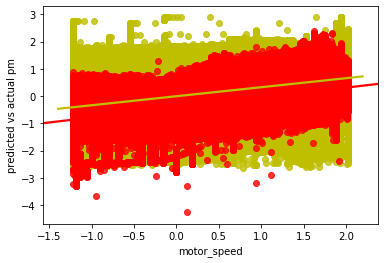

In [28]:
ax1= sns.regplot(x="motor_speed", y=y_test, label="Actual Value", data=X_test, color="y");
ax2 = sns.regplot(x="motor_speed", y=pd.DataFrame(yPredictedTestOls1Inversed, columns=['pm'])["pm"], label="predicted Value", color="r", data=X_test, ax=ax1);
ax1.set_ylabel('predicted vs actual pm')



Text(0, 0.5, &#39;predicted vs actual pm&#39;)

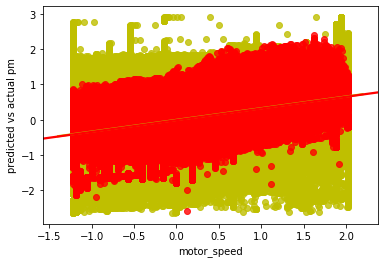

In [40]:
# model withoud scaling
ax1= sns.regplot(x="motor_speed", y=y_test, label="Actual Value", data=X_test, color="y");
ax2 = sns.regplot(x="motor_speed", y=yPredictedTestOls2, label="predicted Value", color="r", data=X_test, ax=ax1);
ax1.set_ylabel('predicted vs actual pm')

In [41]:
 fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(ols, 0, ax=ax)
ax.set_ylabel("pm")

KeyboardInterrupt: 

# KNN

In [3]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, MaxAbsScaler
ss = StandardScaler() # -> 0.773837209163774
#ss = Normalizer() # -> used for NLP TF Idf but what ?
#ss = MinMaxScaler()# -> good 
#ss =    MaxAbsScaler()# ->  0.27318492751506374
# Apply scaler to numeric colu
dfKNN = df.copy()

X=dfKNN.drop(["pm" ,"torque", "stator_tooth",'profile_id','stator_yoke', 'stator_winding'], axis=1)
y=dfKNN["pm"]

coolant = X['coolant']
newCoolant = np.sign(coolant)*np.log(abs(coolant))
df2moisCoolant = X.drop(['coolant'], axis =1)
X['newCoolant'] = newCoolant

from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

X_train_transformed = ss.fit_transform(X_train)
y_train_transformed = ss.fit_transform(pd.DataFrame(y_train, columns =['pm'] ))
X_test_transformed = ss.fit_transform(X_test)
y_test_transformed = ss.fit_transform(pd.DataFrame(y_test, columns =['pm'] ))

In [7]:
rmse_val = [] #to store rmse values for different k
for K in range(10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train_transformed, y_train_transformed)  #fit the model
    pred=model.predict(X_test_transformed) #make prediction on test set
    predinversed = ss.inverse_transform(pred)
    error = mean_squared_error(y_test,predinversed) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)


    #####could be done using GridSearchCV 
#from sklearn.model_selection import GridSearchCV
#params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

#knn = neighbors.KNeighborsRegressor()

#model = GridSearchCV(knn, params, cv=5)
#model.fit(x_train,y_train)
#model.best_params_

RMSE value for k=  1 is: 0.04846402696313817
RMSE value for k=  2 is: 0.04259620279782289
RMSE value for k=  3 is: 0.04269149048514235
RMSE value for k=  4 is: 0.04390162511499325
RMSE value for k=  5 is: 0.04569997512328565
RMSE value for k=  6 is: 0.04761405963082875
RMSE value for k=  7 is: 0.04955279907875533
RMSE value for k=  8 is: 0.051536215282021645
RMSE value for k=  9 is: 0.0533743243699961
RMSE value for k=  10 is: 0.05508639616529116


Text(0.5, 0, &#39;k&#39;)

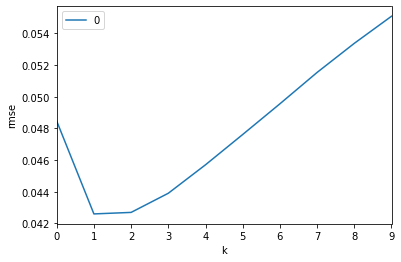

In [8]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
ax =curve.plot()
ax.set_ylabel("rmse")
ax.set_xlabel("k")

In [6]:
rmse_val = [] #to store rmse values for different k
for K in range(10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = mean_squared_error(y_test,pred) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.03975142431107732
RMSE value for k=  2 is: 0.03557551525743878
RMSE value for k=  3 is: 0.03662748899681886
RMSE value for k=  4 is: 0.03859391908698284
RMSE value for k=  5 is: 0.040872582356193767
RMSE value for k=  6 is: 0.04310477187503101
RMSE value for k=  7 is: 0.04536796254169539
RMSE value for k=  8 is: 0.0476748525634031
RMSE value for k=  9 is: 0.049678318327897944
RMSE value for k=  10 is: 0.051571797359813175


In [9]:
knn_model_rs=KNeighborsRegressor(2).fit(X_train, y_train)
y_pred=knn_model_rs.predict(X_test)
y_pred.shape

(199614,)

In [14]:
knn_model=KNeighborsRegressor(2).fit(X_train_transformed, y_train_transformed)
y2_pred=knn_model.predict(X_test_transformed)
y2_predInversed = ss.inverse_transform(y2_pred)
y2_predInversed.shape

(199614, 1)

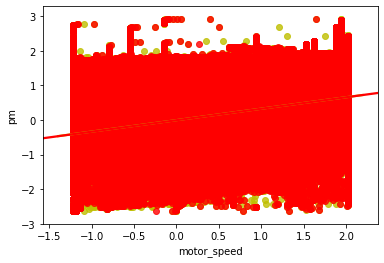

In [12]:
ax1= sns.regplot(x="motor_speed", y=y_test, label="Actual Value", data=X_test, color="y");
sns.regplot(x="motor_speed", y=y_pred, label="predicted Value", color="r", data=X_test, ax=ax1);

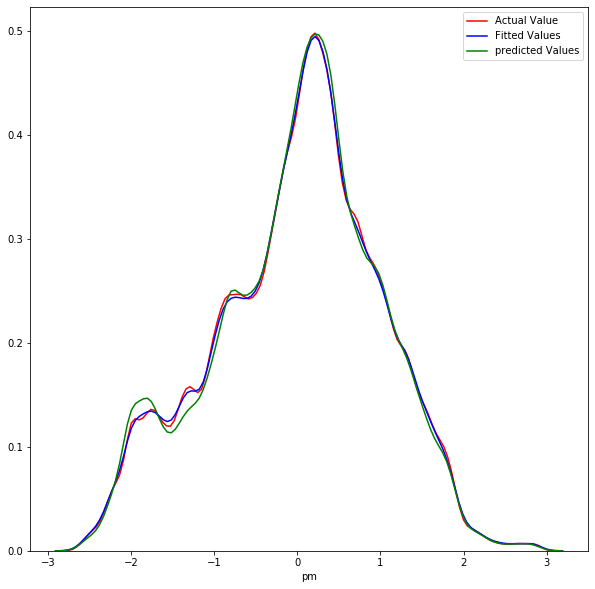

In [15]:

import seaborn as sns
f,ax=plt.subplots(figsize=(10,10))
matplotlib.rcParams.update({'font.size': 10})
ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax1);
sns.distplot(y2_predInversed, hist=False, color="g", label="predicted Values" , ax=ax1);